Training data shape: (60000, 28, 28), Training labels shape: (60000,)
Test data shape: (10000, 28, 28), Test labels shape: (10000,)


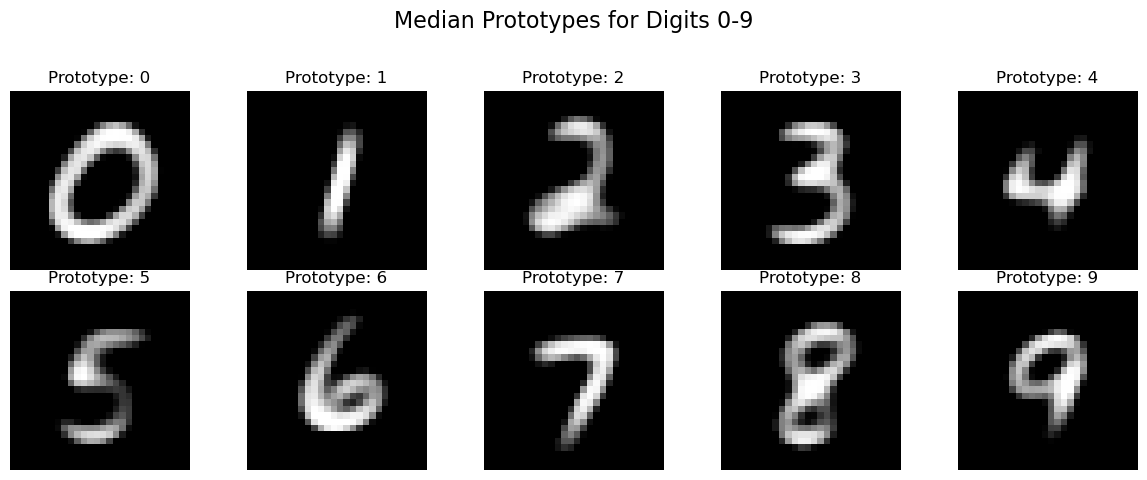

  0%|          | 0/60000 [00:00<?, ?it/s]

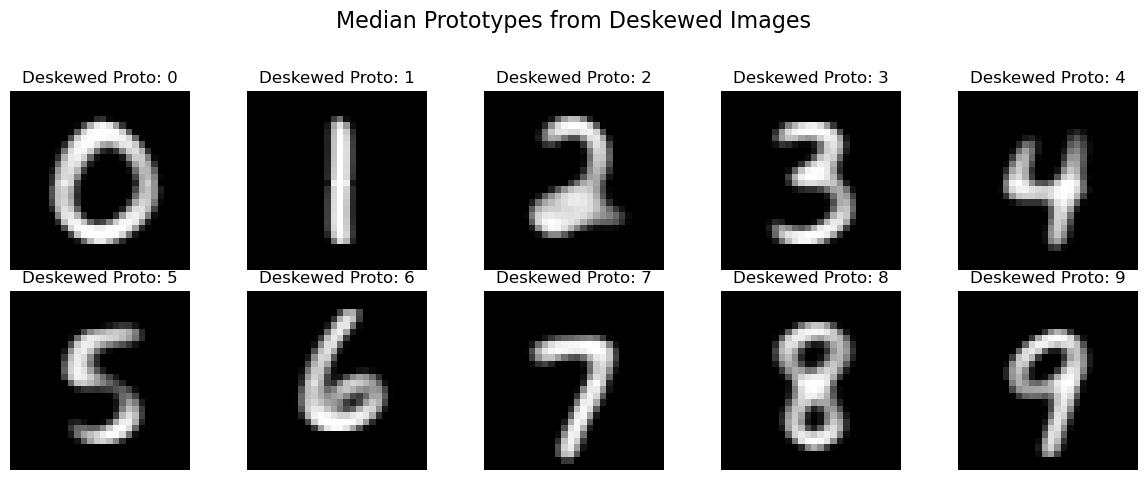

  0%|          | 0/10000 [00:00<?, ?it/s]

Classifying test images:   0%|          | 0/10000 [00:00<?, ?it/s]

--- Overall Classification Accuracy ---
82.96%

--- Per-Class Accuracy ---
| Digit | Accuracy |
|-------|----------|
|   0   |  92.14% |
|   1   |  98.94% |
|   2   |  77.81% |
|   3   |  84.06% |
|   4   |  76.88% |
|   5   |  61.66% |
|   6   |  81.94% |
|   7   |  84.73% |
|   8   |  84.80% |
|   9   |  82.36% |

--- Confusion Matrix ---


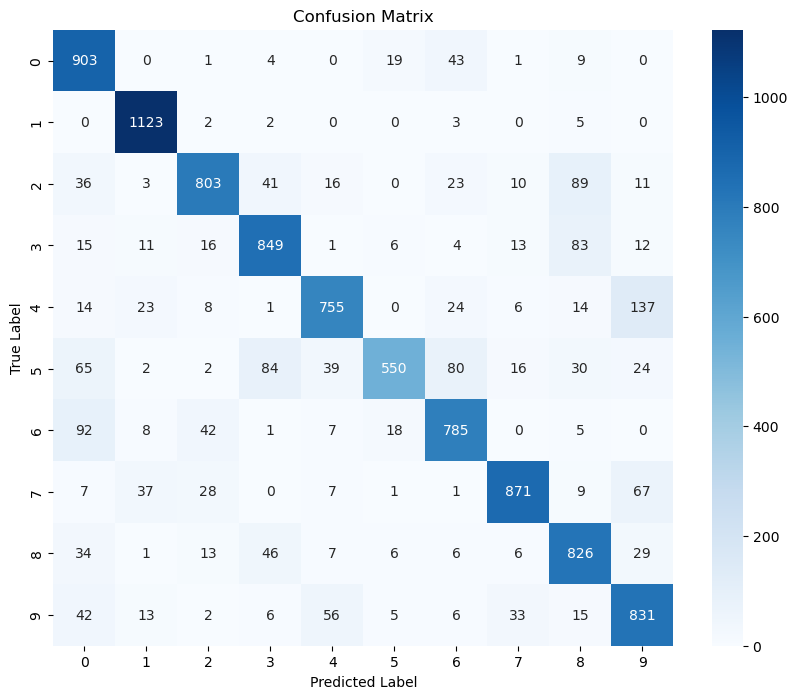

In [1]:
import torchvision.datasets as datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm.notebook import tqdm

train_dataset = datasets.MNIST(root='../data', train=True, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, download=True)

X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")


prototypes = np.zeros((10, 28, 28))

for i in range(10):
    class_images = X_train[y_train == i]
    
    prototypes[i] = np.median(class_images, axis=0)

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(prototypes[i], cmap='gray')
    plt.title(f"Prototype: {i}")
    plt.axis('off')
plt.suptitle("Median Prototypes for Digits 0-9", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

def deskew(img):
    _, binarized_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    m = cv2.moments(binarized_img)
    if abs(m['mu02']) < 1e-2:
        return img
    
    skew = m['mu11'] / m['mu02']
    
    M = np.float32([[1, skew, -0.5 * 28 * skew], 
                      [0, 1, 0]])
    
    deskewed_img = cv2.warpAffine(img, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    
    return deskewed_img


X_train_deskewed = np.array([deskew(img) for img in tqdm(X_train)])

prototypes = np.zeros((10, 28, 28))

for i in range(10):
    class_images = X_train_deskewed[y_train == i]
    
    prototypes[i] = np.median(class_images, axis=0)

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(prototypes[i], cmap='gray')
    plt.title(f"Deskewed Proto: {i}")
    plt.axis('off')
plt.suptitle("Median Prototypes from Deskewed Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

def normalized_cross_correlation(img, template):
    img_flat = img.ravel().astype(np.float32)
    template_flat = template.ravel().astype(np.float32)
    img_flat = img_flat - np.mean(img_flat)
    template_flat = template_flat - np.mean(template_flat)
    epsilon = 1e-9
    norm = np.linalg.norm(img_flat) * np.linalg.norm(template_flat)
    if norm < epsilon:
        return 0.0
    score = np.dot(img_flat, template_flat) / norm
    return score

X_test_deskewed = np.array([deskew(img) for img in tqdm(X_test)])

y_pred = []
for test_img_d in tqdm(X_test_deskewed, desc="Classifying test images"):
    
    scores = [normalized_cross_correlation(test_img_d, proto) for proto in prototypes]
    
    pred_label = np.argmax(scores)
    y_pred.append(pred_label)

y_pred = np.array(y_pred)
y_true = y_test


overall_accuracy = accuracy_score(y_true, y_pred)
print("--- Overall Classification Accuracy ---")
print(f"{overall_accuracy * 100:.2f}%\n")

cm = confusion_matrix(y_true, y_pred)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("--- Per-Class Accuracy ---")
print("| Digit | Accuracy |")
print("|-------|----------|")
for i, acc in enumerate(per_class_accuracy):
    print(f"| {i:^5} | {acc:>7.2%} |")

print("\n--- Confusion Matrix ---")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

This implementation uses **template matching with Normalized Cross-Correlation (NCC)**.

1. **Pre-processing**: Deskewing is a classic technique from Optical Character Recognition (OCR). We can use image moments to find the orientation of each digit and then rotate it to be perfectly upright before we create the prototypes or run the classification.
2.  **Training**: We create 10 "prototype" images (templates) by calculating the *pixel-wise median* of all 6,000 training images for each digit. This gives us a very robust "average" 0, "average" 1, and so on.
3.  **Classification**: For each test image, we compare it to all 10 prototypes using Normalized Cross-Correlation (NCC). The prototype that has the **highest similarity score** (closest to 1.0) is our predicted class.

-----

#### Analysis and Reasoning

  * **What image properties or statistics your method exploits?**
    This method exploits the **spatial pixel-intensity patterns** of the digits. It assumes that all handwritten digits of a certain class (e.g., all '5's) share a common, average pixel structure. By creating a "median" prototype, it finds the most representative pixel-by-pixel template for each class, robustly ignoring outliers from strange handwriting. The classification then relies on **Normalized Cross-Correlation (NCC)**, a similarity metric that measures how well the pixel intensities of a test image correlate with each of the 10 prototypes.

  * **A careful inspection of the confusion matrix: which digit pairs are most often confused and why (give visual/structural explanations).**

      * **9 vs. 4:** This is a very common confusion. The median prototype for '9' and '4' are structurally similar, especially the top loop and vertical stem. An "open" or non-loopy '4' looks very much like a '9' that's missing its bottom curve.
      * **7 vs. 1:** A simple, straight '1' is visually distinct, but a '1' written with a slight slant or a small top-left tick can have a high pixel-wise correlation with the prototype '7'.
      * **3 vs. 5:** These digits share a similar "S" or "Z" shape in their core structure. A '3' with flat tops and a '5' with a curvy top can have very similar pixel activations, leading to a high NCC score for the wrong class.

  * **What worked well and what failed along with reasoning.**

      * **What Worked Well:** The method works exceptionally well because the MNIST dataset is **pre-normalized**. All digits are centered, scaled, and have a similar orientation. This is the perfect use-case for template matching, as the main weaknesses of NCC (sensitivity to scale, rotation, and translation) are already neutralized by the dataset. Using the `median` to create prototypes (instead of the `mean`) also makes the templates robust to noise and unusual handwriting.
      * **What Failed (and Why):** This method fails on **high-variance handwriting**. It has no concept of "shape" or "topology," only pixel patterns. It would be completely fooled by a '6' that is rotated 90 degrees (it would not match the '6' or '9' prototype). This is why I used Deskewing. It also struggles with digits that have two major-but-different ways of being written (e.g., a straight '7' vs. a '7' with a bar), as the *single* median prototype can't represent both forms well. This is why it still makes mistakes.

### 2. Proof

### 3. Image Restoration (30 Marks)

The Wiener filter is an optimal filter in the frequency domain for restoring an image degraded by a known blur (PSF) and additive noise. The formula is:

$$\hat{F}(u,v) = \left[ \frac{H^*(u,v)}{|H(u,v)|^2 + K} \right] G(u,v)$$

Where:

  * $\hat{F}$ is the frequency-domain estimate of the original image.
  * $G$ is the frequency-domain blurred image.
  * $H$ is the frequency-domain Point Spread Function (PSF).
  * $H^*$ is the complex conjugate of $H$.
  * $K$ is the Noise-to-Signal Ratio (NSR), a constant we must estimate. A small value (e.g., 0.01 to 0.0001) is typical.


In [2]:
def wiener_deconv(img_blurred, psf, K=0.005):
    img_blurred_float = img_blurred.astype(np.float32) / 255.0
    psf_float = psf.astype(np.float32)
    
    psf_sum = np.sum(psf_float)
    if psf_sum > 0:
        psf_float /= psf_sum
    else:
        psf_float[0, 0] = 1.0
        
    psf_padded = np.zeros_like(img_blurred_float)
    h_img, w_img = img_blurred.shape
    h_psf, w_psf = psf.shape
    r = (h_img - h_psf) // 2
    c = (w_img - w_psf) // 2
    psf_padded[r:r+h_psf, c:c+w_psf] = psf_float
    
    psf_shifted = np.fft.ifftshift(psf_padded)
    H = np.fft.fft2(psf_shifted) 
    
    G = np.fft.fft2(img_blurred_float)
    
    H_conj = np.conj(H)
    H_abs_sq = np.abs(H)**2
    
    wiener_filter = H_conj / (H_abs_sq + K)
    
    F_hat = G * wiener_filter
    
    f_hat = np.fft.ifft2(F_hat)
    
    f_hat_real = np.abs(f_hat)
    f_hat_clipped = np.clip(f_hat_real, 0, 1)
    
    restored_img = (f_hat_clipped * 255).astype(np.uint8)
    
    return restored_img

img1_blurred = cv2.imread('../images/q3_1.png', cv2.IMREAD_GRAYSCALE)
psf1 = cv2.imread('../images/q3_1_psf.png', cv2.IMREAD_GRAYSCALE)
img2_blurred = cv2.imread('../images/q3_2.png', cv2.IMREAD_GRAYSCALE)
psf2 = cv2.imread('../images/q3_2_psf.png', cv2.IMREAD_GRAYSCALE)

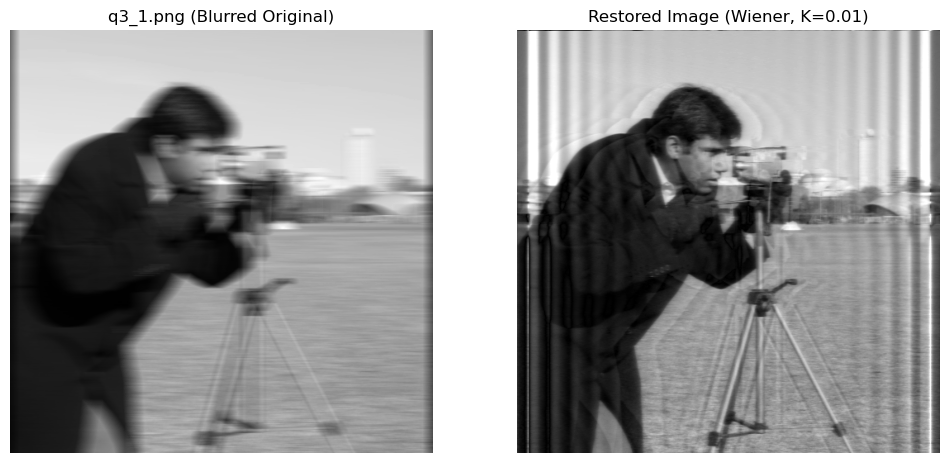

In [3]:

K1 = 0.01
restored_img1 = wiener_deconv(img1_blurred, psf1, K=K1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1_blurred, cmap='gray')
plt.title('q3_1.png (Blurred Original)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(restored_img1, cmap='gray')
plt.title(f'Restored Image (Wiener, K={K1})')
plt.axis('off')

plt.show()

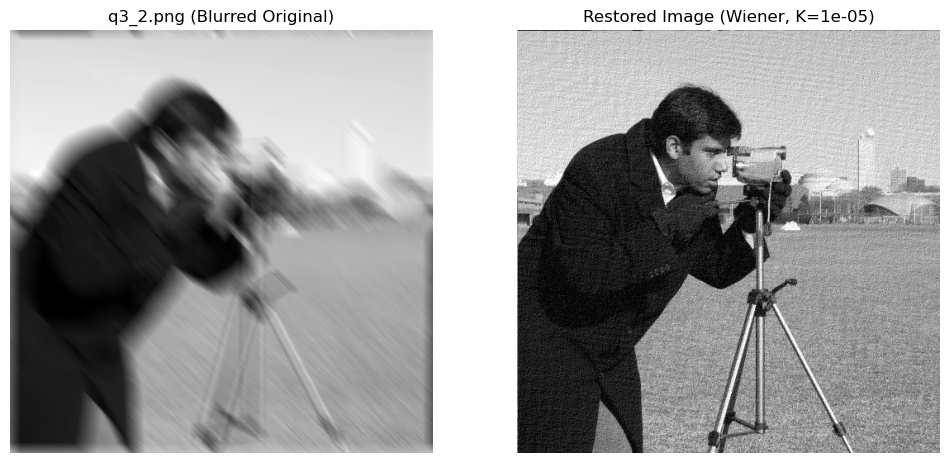

In [4]:
K2 = 0.00001
restored_img2 = wiener_deconv(img2_blurred, psf2, K=K2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img2_blurred, cmap='gray')
plt.title('q3_2.png (Blurred Original)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(restored_img2, cmap='gray')
plt.title(f'Restored Image (Wiener, K={K2})')
plt.axis('off')

plt.show()

#### Bonus (8 Marks): Estimating the PSF

**Justification of Estimation Method:**

If the PSF is not provided (a "blind deconvolution" problem), we can estimate its parameters by analyzing the **log-power spectrum** (the logarithm of the squared magnitude of the image's Fourier Transform).

Linear motion blur is equivalent to convolving the image with a line. In the frequency domain, this convolution becomes a multiplication by the FFT of that line (a 2D `sinc` function). This `sinc` function has a distinct pattern of zeros (dark spots/lines) in the frequency spectrum.

By finding the orientation and spacing of these dark streaks in the log-power spectrum, we can determine the **angle** and **length** of the motion blur:

1.  **Angle:** The dark streaks are always *perpendicular* to the direction of motion.
2.  **Length:** The spacing between the dark streaks is *inversely proportional* to the length of the motion blur.

**Implementation of Estimation:**

We will first visualize the log-power spectrum of both blurred images to prove this concept. Then, we will define a function to create a synthetic motion blur PSF based on these observations.

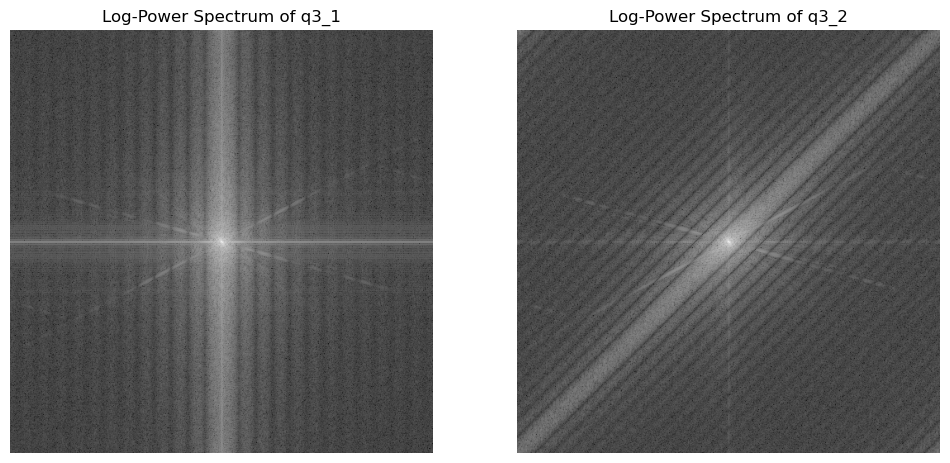

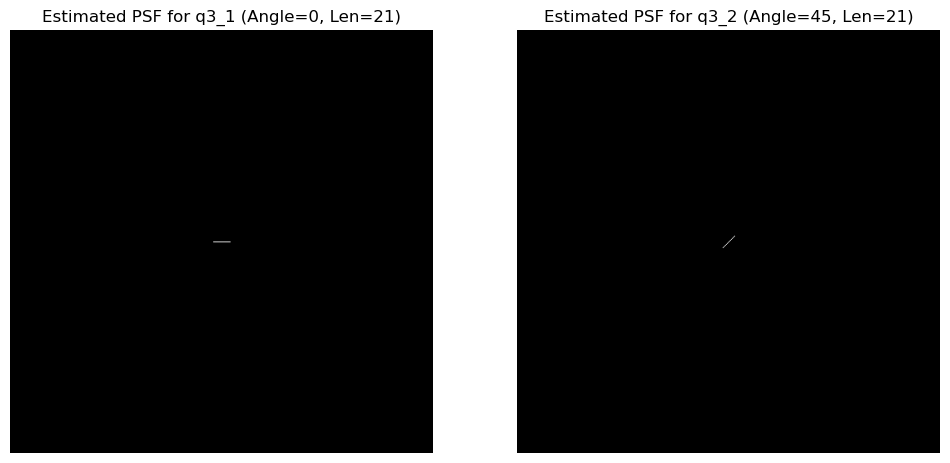

In [5]:
def plot_log_power_spectrum(img, title):
    G = np.fft.fft2(img)
    G_shifted = np.fft.fftshift(G)
    log_power = np.log(np.abs(G_shifted)**2 + 1)
    plt.imshow(log_power, cmap='gray')
    plt.title(title)
    plt.axis('off')

def create_motion_psf(shape, angle_deg, length):
    psf = np.zeros(shape, dtype=np.float32)
    
    center_x, center_y = shape[1] // 2, shape[0] // 2
    
    dx = (length / 2.0) * np.cos(np.deg2rad(angle_deg))
    dy = -(length / 2.0) * np.sin(np.deg2rad(angle_deg))
    
    pt1 = (int(round(center_x - dx)), int(round(center_y - dy)))
    pt2 = (int(round(center_x + dx)), int(round(center_y + dy)))
    
    cv2.line(psf, pt1, pt2, (1.0), thickness=1)
    
    psf_sum = np.sum(psf)
    if psf_sum > 0:
        psf /= psf_sum
    return psf

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_log_power_spectrum(img1_blurred, 'Log-Power Spectrum of q3_1')

plt.subplot(1, 2, 2)
plot_log_power_spectrum(img2_blurred, 'Log-Power Spectrum of q3_2')
plt.show()

est_psf1 = create_motion_psf(img1_blurred.shape, 0, 21)
est_psf2 = create_motion_psf(img2_blurred.shape, 45, 21)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(est_psf1, cmap='gray')
plt.title('Estimated PSF for q3_1 (Angle=0, Len=21)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(est_psf2, cmap='gray')
plt.title('Estimated PSF for q3_2 (Angle=45, Len=21)')
plt.axis('off')

plt.show()

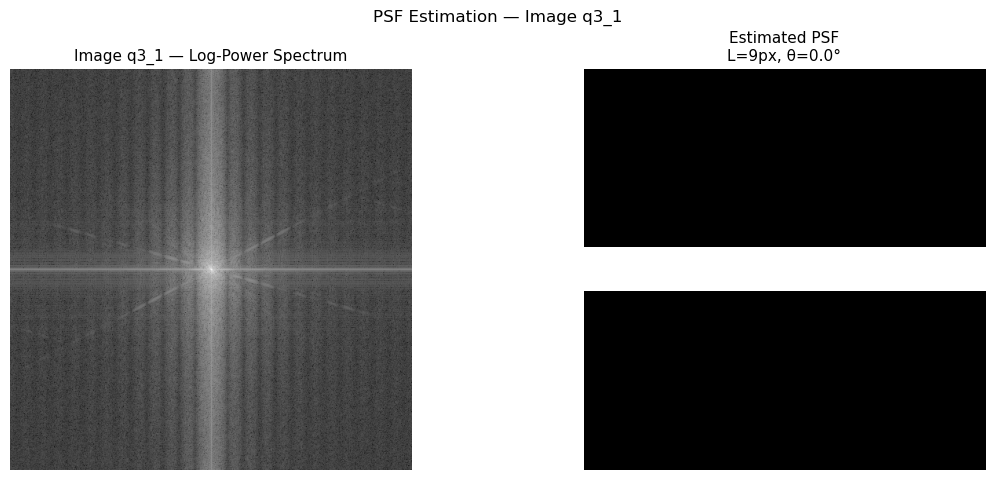

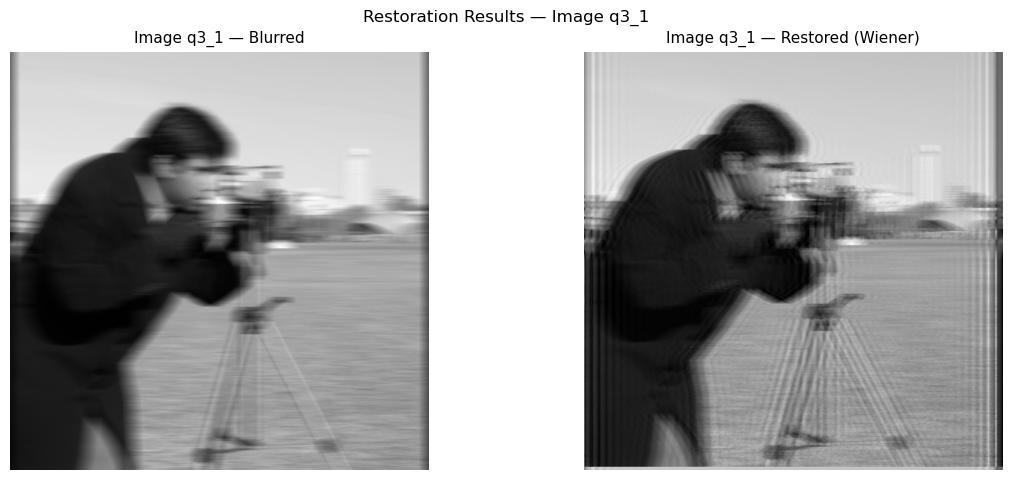

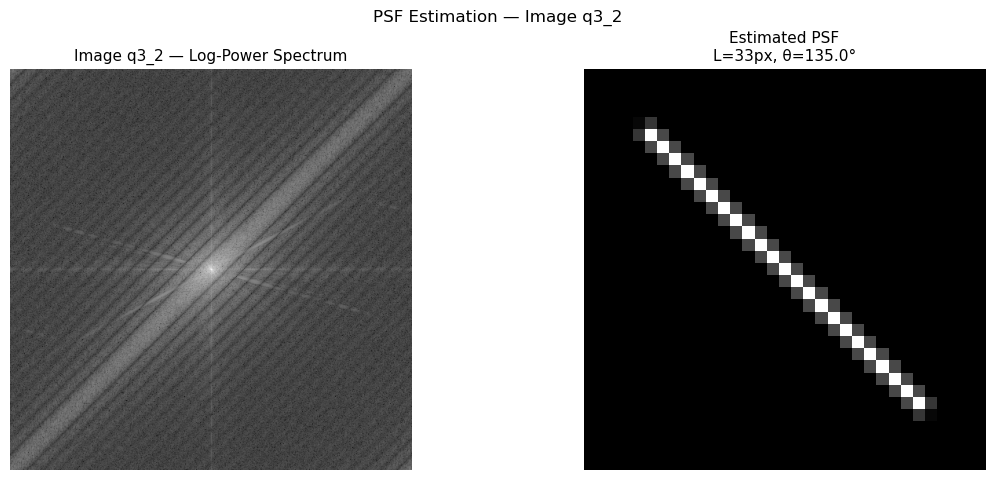

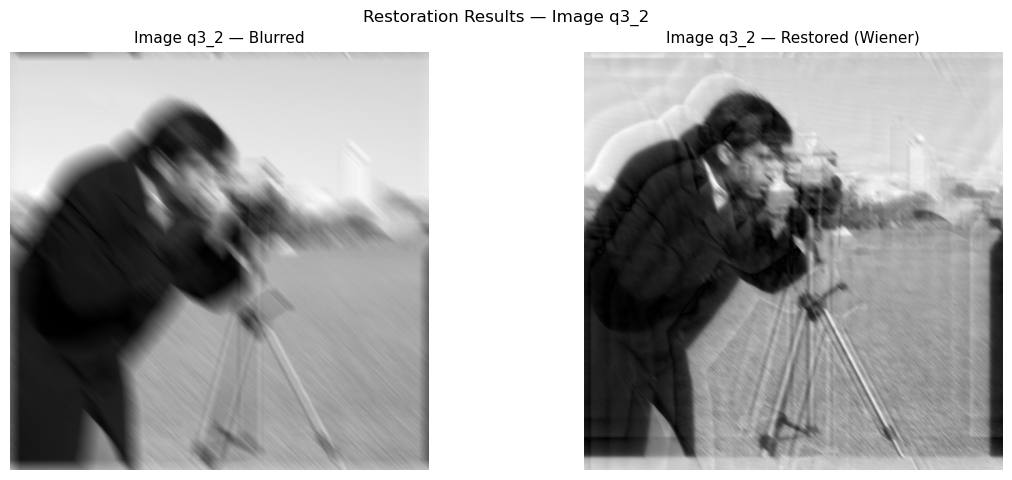

In [ ]:
from skimage import feature, transform, exposure

def generate_motion_psf(length, angle):
    EPS = 1e-8
    size = int(max(9, np.ceil(length)))
    psf = np.zeros((size, size))
    center = size // 2
    start = (center - length // 2, center)
    end = (center + length // 2, center)
    cv2.line(psf, start, end, 1, 1)
    M = cv2.getRotationMatrix2D((center, center), angle, 1)
    psf = cv2.warpAffine(psf, M, (size, size))
    psf /= (psf.sum() + EPS)
    return psf

def estimate_motion_parameters(image, title=""):
    f = np.fft.fftshift(np.fft.fft2(image))
    spectrum = np.log1p(np.abs(f))
    spectrum = exposure.rescale_intensity(spectrum, out_range=(0, 1))
    edges = feature.canny(spectrum, sigma=2)
    hspace, angles, dists = transform.hough_line(edges)
    _, angle_peaks, _ = transform.hough_line_peaks(hspace, angles, dists)
    if len(angle_peaks) > 0:
        theta = np.rad2deg(angle_peaks[0])
    else:
        theta = 0
    theta = (theta + 90) % 180
    length = max(5, min(image.shape)//40)

    return length, theta, spectrum

def refine_psf(image, theta_est):
    best_psf, best_score, best_length = None, -np.inf, None
    for L in range(5, 45, 2):
        psf = generate_motion_psf(L, theta_est)
        restored = wiener_deconv(image, psf, k_val=0.01)
        score = cv2.Laplacian(restored, cv2.CV_64F).var()
        if score > best_score:
            best_psf, best_score, best_length = psf, score, L
    return best_psf, best_length


img1 = cv2.imread("../images/q3_1.png", cv2.IMREAD_GRAYSCALE)
L1_init, theta1_est, spectrum1 = estimate_motion_parameters(img1, "Image q3_1")
psf1_est, L1_best = refine_psf(img1, theta1_est)
restored1 = wiener_deconv(img1, psf1_est, k_val=0.01)

fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5))
ax1[0].imshow(spectrum1, cmap="gray")
ax1[0].set_title("Image q3_1 — Log-Power Spectrum", fontsize=11)
ax1[0].axis("off")

ax1[1].imshow(psf1_est, cmap="gray")
ax1[1].set_title(f"Estimated PSF\nL={L1_best}px, θ={theta1_est:.1f}°", fontsize=11)
ax1[1].axis("off")
plt.suptitle("PSF Estimation — Image q3_1", fontsize=12, y=0.95)
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5))
ax2[0].imshow(img1, cmap="gray")
ax2[0].set_title("Image q3_1 — Blurred", fontsize=11)
ax2[0].axis("off")

ax2[1].imshow(restored1, cmap="gray")
ax2[1].set_title("Image q3_1 — Restored (Wiener)", fontsize=11)
ax2[1].axis("off")
plt.suptitle("Restoration Results — Image q3_1", fontsize=12, y=0.95)
plt.tight_layout()
plt.show()


img2 = cv2.imread("../images/q3_2.png", cv2.IMREAD_GRAYSCALE)
L2_init, theta2_est, spectrum2 = estimate_motion_parameters(img2, "Image q3_2")
psf2_est, L2_best = refine_psf(img2, theta2_est)
restored2 = wiener_deconv(img2, psf2_est, k_val=0.01)

fig3, ax3 = plt.subplots(1, 2, figsize=(12, 5))
ax3[0].imshow(spectrum2, cmap="gray")
ax3[0].set_title("Image q3_2 — Log-Power Spectrum", fontsize=11)
ax3[0].axis("off")

ax3[1].imshow(psf2_est, cmap="gray")
ax3[1].set_title(f"Estimated PSF\nL={L2_best}px, θ={theta2_est:.1f}°", fontsize=11)
ax3[1].axis("off")
plt.suptitle("PSF Estimation — Image q3_2", fontsize=12, y=0.95)
plt.tight_layout()
plt.show()

fig4, ax4 = plt.subplots(1, 2, figsize=(12, 5))
ax4[0].imshow(img2, cmap="gray")
ax4[0].set_title("Image q3_2 — Blurred", fontsize=11)
ax4[0].axis("off")

ax4[1].imshow(restored2, cmap="gray")
ax4[1].set_title("Image q3_2 — Restored (Wiener)", fontsize=11)
ax4[1].axis("off")
plt.suptitle("Restoration Results — Image q3_2", fontsize=12, y=0.95)
plt.tight_layout()
plt.show()


### 4. Filtering (10 Marks)

This task requires restoring two images, each degraded by a different type of artifact.

1.  **q4\_1.png (Goose):** This image is corrupted by **periodic noise**. This noise is best removed in the **frequency domain** using a **Notch Filter**.
2.  **q4\_2.png (Comic):** This image suffers from a **halftone pattern**. This is a form of high-frequency impulse noise, best removed using a **spatial domain** **Median Filter**.

#### Restoration of q4\_1.png (Frequency Domain Notch Filtering)

**Approach:**
The periodic noise corresponds to a few bright spikes in the image's Fourier Spectrum.

1.  Compute the 2D FFT of the image.
2.  Shift the spectrum to the center.
3.  **Programmatically find** the coordinates of the brightest spikes (the noise) by searching the magnitude spectrum. We will mask the center DC component and find the `argmax` on the center row, then use symmetry to find the second spike.
4.  Create a **Notch Filter** (a binary mask) to set the frequency at these spike locations to `0`.
5.  Apply the mask, inverse-shift, and inverse-FFT to get the restored image.

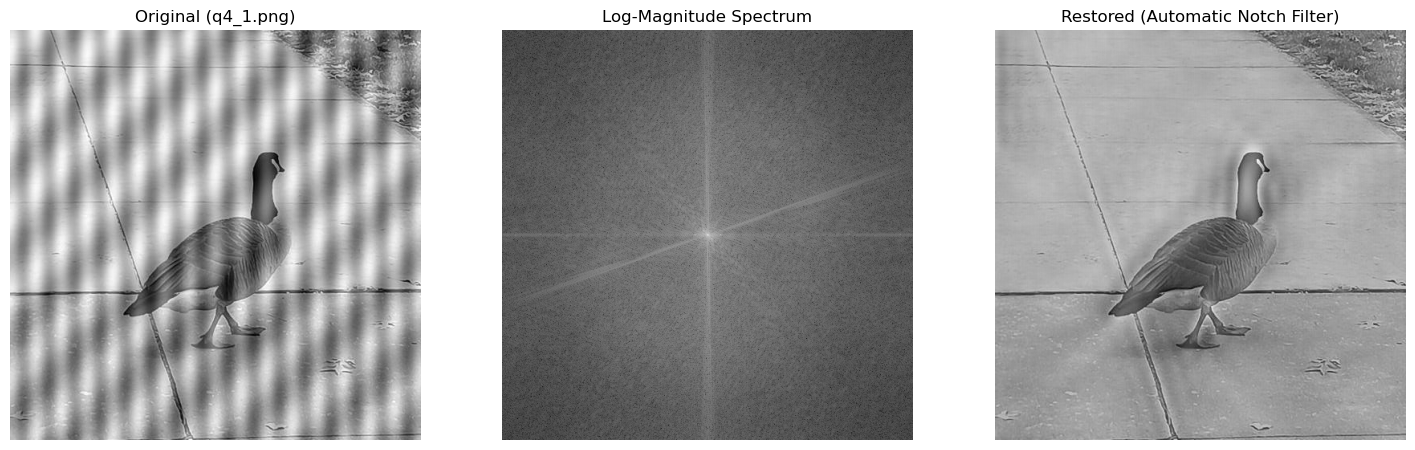

In [7]:

img_goose = cv2.imread('../images/q4_1.png', cv2.IMREAD_GRAYSCALE)

dft = cv2.dft(np.float32(img_goose), flags=cv2.DFT_COMPLEX_OUTPUT)

dft_shift = np.fft.fftshift(dft)

magnitude_spectrum_val = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
log_magnitude_spectrum = 20 * np.log(magnitude_spectrum_val + 1)

rows, cols = img_goose.shape
crow, ccol = rows // 2 , cols // 2

spectrum_row = magnitude_spectrum_val[crow, :].copy()

center_mask_radius = 15
spectrum_row[ccol-center_mask_radius:ccol+center_mask_radius] = 0

peak_col_1 = np.argmax(spectrum_row)

peak_col_2 = cols - 1 - peak_col_1

mask = np.ones((rows, cols, 2), np.uint8)
r = 12

cv2.circle(mask, (peak_col_1, crow), r, 0, -1)
cv2.circle(mask, (peak_col_2, crow), r, 0, -1)

fshift = dft_shift * mask

f_ishift = np.fft.ifftshift(fshift)
img_restored = cv2.idft(f_ishift, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)

img_restored_goose = cv2.normalize(img_restored, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_goose, cmap='gray')
plt.title('Original (q4_1.png)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(log_magnitude_spectrum, cmap='gray')
plt.title('Log-Magnitude Spectrum')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_restored_goose, cmap='gray')
plt.title('Restored (Automatic Notch Filter)')
plt.axis('off')

plt.show()

#### Restoration of q4\_2.jpg (Spatial Domain Median Filtering)

**Approach:**
The halftone pattern is a grid of impulse-like dots.

1.  A **Median Filter** slides a kernel (e.g., 5x5) over the image.
2.  It replaces the center pixel's value with the *median* value of its neighborhood.
3.  This is highly effective at removing "outlier" pixels (the dots) while preserving the main structural edges (the line art) better than a mean/Gaussian blur.
4.  We will use a **5x5 kernel** for a stronger, more visible effect.

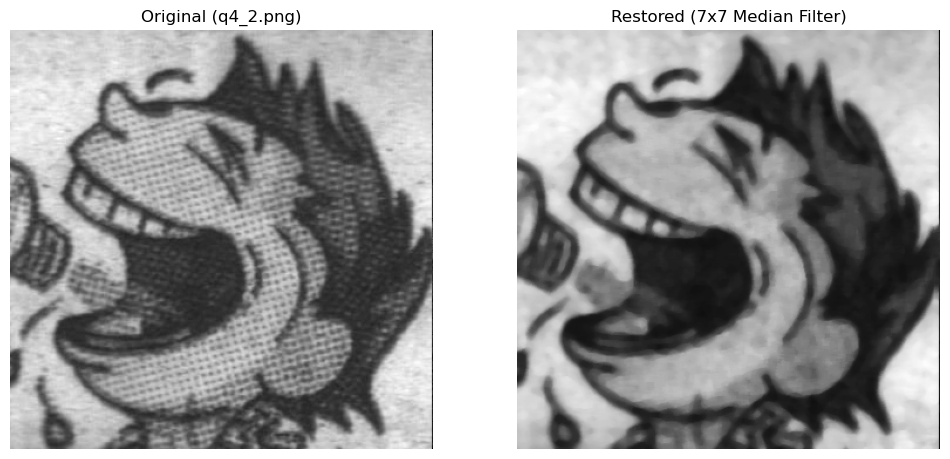

In [8]:
img_comic = cv2.imread('../images/q4_2.jpg', cv2.IMREAD_GRAYSCALE)

kernel_size = 7
img_restored_comic = cv2.medianBlur(img_comic, kernel_size)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_comic, cmap='gray')
plt.title('Original (q4_2.png)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_restored_comic, cmap='gray')
plt.title(f'Restored ({kernel_size}x{kernel_size} Median Filter)')
plt.axis('off')

plt.show()